# PDAC Multi-omics Integration & Prediction Pipeline

**Contents:**

1. Load CSVs (circRNA, miRNA, mRNA, phosphoproteome gene, SCNA gene, clinical data)
2. Preprocess (filter, z-score)

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import SpectralClustering
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score
from sklearn.metrics import pairwise_distances
print('ready')


ready


In [2]:
# Load files
base_path = 'PDAC_data'
files = os.listdir(base_path)
print('files in /PDAC_data:', files)

def try_read(path):
    try:
        return pd.read_csv(path, index_col=0)
    except Exception as e:
        print('Could not read', path, '->', e)
        return None

circ = try_read(os.path.join(base_path,'circRNA.csv'))
mir = try_read(os.path.join(base_path,'miRNA.csv'))
mrna = try_read(os.path.join(base_path,'mRNA.csv'))
phospho = try_read(os.path.join(base_path,'phosphoproteome_gene.csv'))
proteome = try_read(os.path.join(base_path,'proteome_gene.csv'))
scna = try_read(os.path.join(base_path,'SCNA_gene.csv'))
clin = try_read(os.path.join(base_path,'clinical_data.csv'))

print('circ shape', circ.shape)
print('mir shape',  mir.shape)
print('mrna shape', mrna.shape)
print('phospho shape', phospho.shape)
print('proteome shape', proteome.shape)
print('scna shape', scna.shape)
print('clinical data shape', clin.shape)


files in /PDAC_data: ['circRNA.csv', 'clinical_data.csv', 'miRNA.csv', 'mRNA.csv', 'phosphoproteome_gene.csv', 'proteome_gene.csv', 'SCNA_gene.csv', 'unused data']
circ shape (3979, 137)
mir shape (2416, 137)
mrna shape (28057, 137)
phospho shape (8004, 137)
proteome shape (11662, 137)
scna shape (19906, 137)
clinical data shape (140, 24)
circ shape (3979, 137)
mir shape (2416, 137)
mrna shape (28057, 137)
phospho shape (8004, 137)
proteome shape (11662, 137)
scna shape (19906, 137)
clinical data shape (140, 24)


In [ ]:
def preprocess_clinical(df):
    df = df.copy()

    # Drop useless columns
    df = df.drop(columns=['histology_diagnosis'], errors='ignore')

    # Normalize string columns (strip whitespace)
    obj_cols = df.select_dtypes(include=['object']).columns.tolist()
    for c in obj_cols:
        df[c] = df[c].apply(lambda x: x.strip() if isinstance(x, str) else x)

    # ------------------------
    # Binary encoding
    # ------------------------
    bin_map = {'male':0, 'female':1,
               'yes':1, 'no':0,
               'present':1, 'Notidentified':0,
               'living':0, 'deceased':1}
    bin_cols = ['sex', 'tumor_necrosis', 'lymph_vascular_invasion', 
                'perineural_invasion', 'is_this_patient_lost_to_follow_up', 
                'vital_status']
    for col in bin_cols:
        if col in df.columns:
            df[col] = df[col].astype(str).str.lower().map(bin_map).astype(float)

    # ------------------------
    # Ordinal encoding
    # ------------------------
    pN_map = {'pN0':0, 'pN1':1, 'pN2':2, 'pNX':np.nan}
    pT_map = {'pT1a':1, 'pT1c':1, 'pT2':2, 'pT3':3, 'pT4':4, 'pTX':np.nan}
    pM_map = {'pM0':0, 'pM1':1, 'pMX':np.nan}
    cM_map = {'cM0':0, 'cM1':1, 'cMX':np.nan}

    if 'pathologic_staging_regiol_lymph_nodes_pn' in df.columns:
        df['pn_num'] = df['pathologic_staging_regiol_lymph_nodes_pn'].map(pN_map)
    if 'pathologic_staging_primary_tumor_pt' in df.columns:
        df['pt_num'] = df['pathologic_staging_primary_tumor_pt'].map(pT_map)
    if 'pathologic_staging_distant_metastasis_pm' in df.columns:
        df['pm_num'] = df['pathologic_staging_distant_metastasis_pm'].map(pM_map)
    if 'clinical_staging_distant_metastasis_cm' in df.columns:
        df['cm_num'] = df['clinical_staging_distant_metastasis_cm'].map(cM_map)

    # Residual tumor
    if 'residual_tumor' in df.columns:
        df['residual_simple'] = df['residual_tumor'].astype(str).str.extract(r'(R[0-2]|RX)', expand=False)
        res_map = {'R0':0, 'R1':1, 'R2':2, 'RX':np.nan}
        df['residual_num'] = df['residual_simple'].map(res_map)
        df = df.drop(columns=['residual_simple'])

    # Tumor stage
    if 'tumor_stage_pathological' in df.columns:
        stage_map = {'I':1, 'II':2, 'III':3, 'IV':4}
        def map_stage(v):
            if not isinstance(v, str):
                return np.nan
            v = v.upper()
            for k in stage_map:
                if k in v:
                    return stage_map[k]
            return np.nan
        df['tumor_stage_num'] = df['tumor_stage_pathological'].map(map_stage)

    # Alcohol consumption (ordered)
    alcohol_map = {
        'lifelong non-drinker':0,
        'consumed alcohol in the past, but currently a non-drinker':1,
        'alcohol consumption <= 2 drinks per day for men and <=1 drink per day for women':2,
        'alcohol consumption > 2 drinks per day for men and >1 drink per day for women':3,
        'alcohol consumption history not available':np.nan
    }
    if 'alcohol_consumption' in df.columns:
        df['alcohol_num'] = df['alcohol_consumption'].str.lower().map(lambda x: alcohol_map.get(x, np.nan))

    # Tobacco smoking (ordered)
    tobacco_map = {
        'lifelong non-smoker: less than 100 cigarettes smoked in lifetime':0,
        'current reformed smoker, more than 15 years':1,
        'current reformed smoker within past 15 years':2,
        'current reformed smoker, years unknown':3,
        'current smoker: includes daily and non-daily smokers':4,
        'smoking history not available':np.nan
    }
    if 'tobacco_smoking_history' in df.columns:
        df['tobacco_num'] = df['tobacco_smoking_history'].str.lower().map(lambda x: tobacco_map.get(x, np.nan))

    # ------------------------
    # One-hot encoding
    # ------------------------
    one_hot_cols = ['race', 'participant_country', 'tumor_site', 
                    'cause_of_death', 'additional_pathologic_findings']
    for col in one_hot_cols:
        if col in df.columns:
            dummies = pd.get_dummies(df[col], prefix=col, dummy_na=False)
            # Convert to float explicitly to be safe
            dummies = dummies.astype(float)
            df = pd.concat([df, dummies], axis=1)
            df = df.drop(columns=[col])

    # ------------------------
    # Keep numeric columns
    # ------------------------
    numeric_df = df.select_dtypes(include=[np.number]).copy()

    # Fill NaNs with 0 for downstream MOFA
    numeric_df = numeric_df.fillna(0)

    return numeric_df

clinical_processed = preprocess_clinical(clin)

# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', 200)
# print(clinical_processed)

           age  sex  tumor_size_cm  tumor_necrosis  lymph_vascular_invasion  perineural_invasion    bmi  follow_up_days  vital_status  is_this_patient_lost_to_follow_up  pn_num  pt_num  pm_num  \
case_id                                                                                                                                                                                            
C3L-00017   69  0.0            4.5             0.0                      0.0                  1.0  28.36           426.0           0.0                                1.0     0.0     3.0     0.0   
C3L-00102   42  0.0            3.0             0.0                      1.0                  1.0  26.93           249.0           1.0                                0.0     2.0     2.0     0.0   
C3L-00189   68  1.0            2.7             0.0                      0.0                  1.0  34.28          1035.0           1.0                                0.0     1.0     2.0     0.0   
C3L-00277   69  0.0 

In [25]:
# Extract sample IDs from omics datasets (columns)
circ_ids = set(circ.columns.astype(str)) if circ is not None else set()
mir_ids  = set(mir.columns.astype(str)) if mir is not None else set()
mrna_ids = set(mrna.columns.astype(str)) if mrna is not None else set()
phospho_ids = set(phospho.columns.astype(str)) if phospho is not None else set()
proteome_ids = set(proteome.columns.astype(str)) if proteome is not None else set()
scna_ids = set(scna.columns.astype(str)) if scna is not None else set()

# Extract sample IDs from clinical (row index)
clinical_processed = set(clin.index.astype(str)) if clin is not None else set()

# Intersect across all datasets that exist
common = circ_ids & mir_ids & mrna_ids & phospho_ids & proteome_ids & scna_ids & clinical_processed

print("circ IDs:", len(circ_ids))
print("mir IDs:",  len(mir_ids))
print("mrna IDs:", len(mrna_ids))
print("phospho IDs:", len(phospho_ids))
print("proteome IDs:", len(proteome_ids))
print("scna IDs:", len(scna_ids))
print("clinical IDs:", len(clinical_processed))
print("common samples:", len(common))

circ IDs: 137
mir IDs: 137
mrna IDs: 137
phospho IDs: 137
proteome IDs: 137
scna IDs: 137
clinical IDs: 140
common samples: 137


In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

def preprocess_omics(df, min_nonzero_frac=0.05, top_var=None):
    df = df.copy()

    # Keep features with sufficient non-zero entries
    nz_frac = (df.notna() & (df != 0)).sum(axis=1) / df.shape[1]
    df = df.loc[nz_frac >= min_nonzero_frac]

    # Select top variable features if requested
    if top_var is not None and df.shape[0] > top_var:
        var = df.var(axis=1)
        keep = var.sort_values(ascending=False).index[:top_var]
        df = df.loc[keep]

    # Z-score standardize features across samples
    scaler = StandardScaler(with_mean=True, with_std=True)
    mat = scaler.fit_transform(df.T).T  # scale features across samples

    return pd.DataFrame(mat, index=df.index, columns=df.columns)

# Subset datasets to common samples and preprocess
common_list = sorted(list(common))  # assume common exists and is not empty

circ_z = preprocess_omics(circ[common_list], min_nonzero_frac=0.01, top_var=None)
mir_z = preprocess_omics(mir[common_list], min_nonzero_frac=0.01, top_var=None)
mrna_z = preprocess_omics(mrna[common_list], min_nonzero_frac=0.01, top_var=None)
phospho_z = preprocess_omics(phospho[common_list], min_nonzero_frac=0.01, top_var=None)
proteome_z = preprocess_omics(proteome[common_list], min_nonzero_frac=0.01, top_var=None)
scna_z = preprocess_omics(scna[common_list], min_nonzero_frac=0.01, top_var=None)

# Print preprocessed shapes
print('preprocessed shapes:')
print('circ_z', circ_z.shape)
print('mir_z ', mir_z.shape)
print('mrna_z', mrna_z.shape)
print('phospho_z', phospho_z.shape)
print('proteome_z', proteome_z.shape)
print('scna_z', scna_z.shape)

preprocessed shapes:
circ_z (2185, 137)
mir_z  (2262, 137)
mrna_z (25701, 137)
phospho_z (7951, 137)
proteome_z (11631, 137)
scna_z (19892, 137)
printing common list: ['C3L-00017', 'C3L-00102', 'C3L-00189', 'C3L-00277', 'C3L-00401', 'C3L-00589', 'C3L-00598', 'C3L-00599', 'C3L-00622', 'C3L-00625', 'C3L-00640', 'C3L-00819', 'C3L-00881', 'C3L-00928', 'C3L-01031', 'C3L-01036', 'C3L-01037', 'C3L-01051', 'C3L-01052', 'C3L-01053', 'C3L-01054', 'C3L-01124', 'C3L-01328', 'C3L-01453', 'C3L-01598', 'C3L-01637', 'C3L-01662', 'C3L-01687', 'C3L-01689', 'C3L-01703', 'C3L-01971', 'C3L-02109', 'C3L-02112', 'C3L-02116', 'C3L-02118', 'C3L-02463', 'C3L-02604', 'C3L-02606', 'C3L-02610', 'C3L-02613', 'C3L-02701', 'C3L-02809', 'C3L-02897', 'C3L-02899', 'C3L-03123', 'C3L-03356', 'C3L-03388', 'C3L-03394', 'C3L-03395', 'C3L-03628', 'C3L-03630', 'C3L-03632', 'C3L-03635', 'C3L-03639', 'C3L-03743', 'C3L-04027', 'C3L-04072', 'C3L-04080', 'C3L-04473', 'C3L-04475', 'C3L-04479', 'C3L-04495', 'C3L-04848', 'C3L-04853', 

In [31]:
# --- MOFA setup and per-view data loading (works with mofapy2 0.7.2) ---
# This cell re-prepares views as samples x features, converts each to
# features x samples and calls mofapy2.entry_point.set_data_matrix per view.

try:
    # Create ordered sample list and views in case notebook state changed
    sample_order = [str(s) for s in sorted(list(common))]
    views = {}
    for name, df in [('circ', circ_z), ('mir', mir_z), ('mrna', mrna_z),
                     ('phospho', phospho_z), ('proteome', proteome_z), ('scna', scna_z)]:
        if df is None:
            print(f'skipping {name}: None')
            continue
        mat = df.T.copy()  # samples x features
        mat.index = mat.index.astype(str)
        mat = mat.loc[mat.index.intersection(sample_order)]
        mat = mat.reindex(sample_order)
        nz_cols = mat.columns[mat.var(axis=0, skipna=True) != 0]
        mat = mat.loc[:, nz_cols]
        views[name] = mat

    ordered_names = [k for k in ['circ','mir','mrna','phospho','proteome','scna'] if k in views]
    views_list = [views[k] for k in ordered_names]  # each is samples x features

    # Import mofapy2 and create entry point
    from mofapy2.run.entry_point import entry_point
    ep = entry_point()
    print('Created MOFA entry point')

    # Load each view using set_data_matrix(view_matrix, views_names=[viewname])
    for vname, df in zip(ordered_names, views_list):
        # convert to features x samples numpy array as expected by this API
        mat_fx_s = df.T.values
        try:
            ep.set_data_matrix(mat_fx_s, views_names=[vname])
            print(f'Loaded view {vname} with shape (features x samples) = {mat_fx_s.shape}')
        except Exception as e_call:
            print(f'Failed loading view {vname}:', e_call)

    # Set view names and model/training options (adjust factors as needed)
    ep.set_data_options()
    ep.set_model_options(factors=10)
    ep.set_train_options(seed=0)

    ep.build()
    ep.run()

except Exception as e:
    print('Error preparing MOFA entry point:', e)

import datetime
output_file = f"trained_mofa_model_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.hdf5"
ep.save(output_file)
print(f"Model saved to {output_file}")


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Created MOFA entry point
Features names not provided, using default naming convention:
- feature1_view1, featureD_viewM

Groups names not provided, using default naming convention:
- group1, group2, ..., groupG

Samples names not provided, using default naming convention:
- sample1_group1, sample2_group1, sample1_group2, ..., sampleN_groupG

Successfully loaded view='circ' group

Loading most recent MOFA model: trained_mofa_model_20251121_182000.hdf5
MOFA+ model: trained mofa model 20251121 182000
Samples (cells): 19892
Features: 137
Groups: group0 (19892)
Views: scna (137)
Factors: 10
Expectations: W, Z


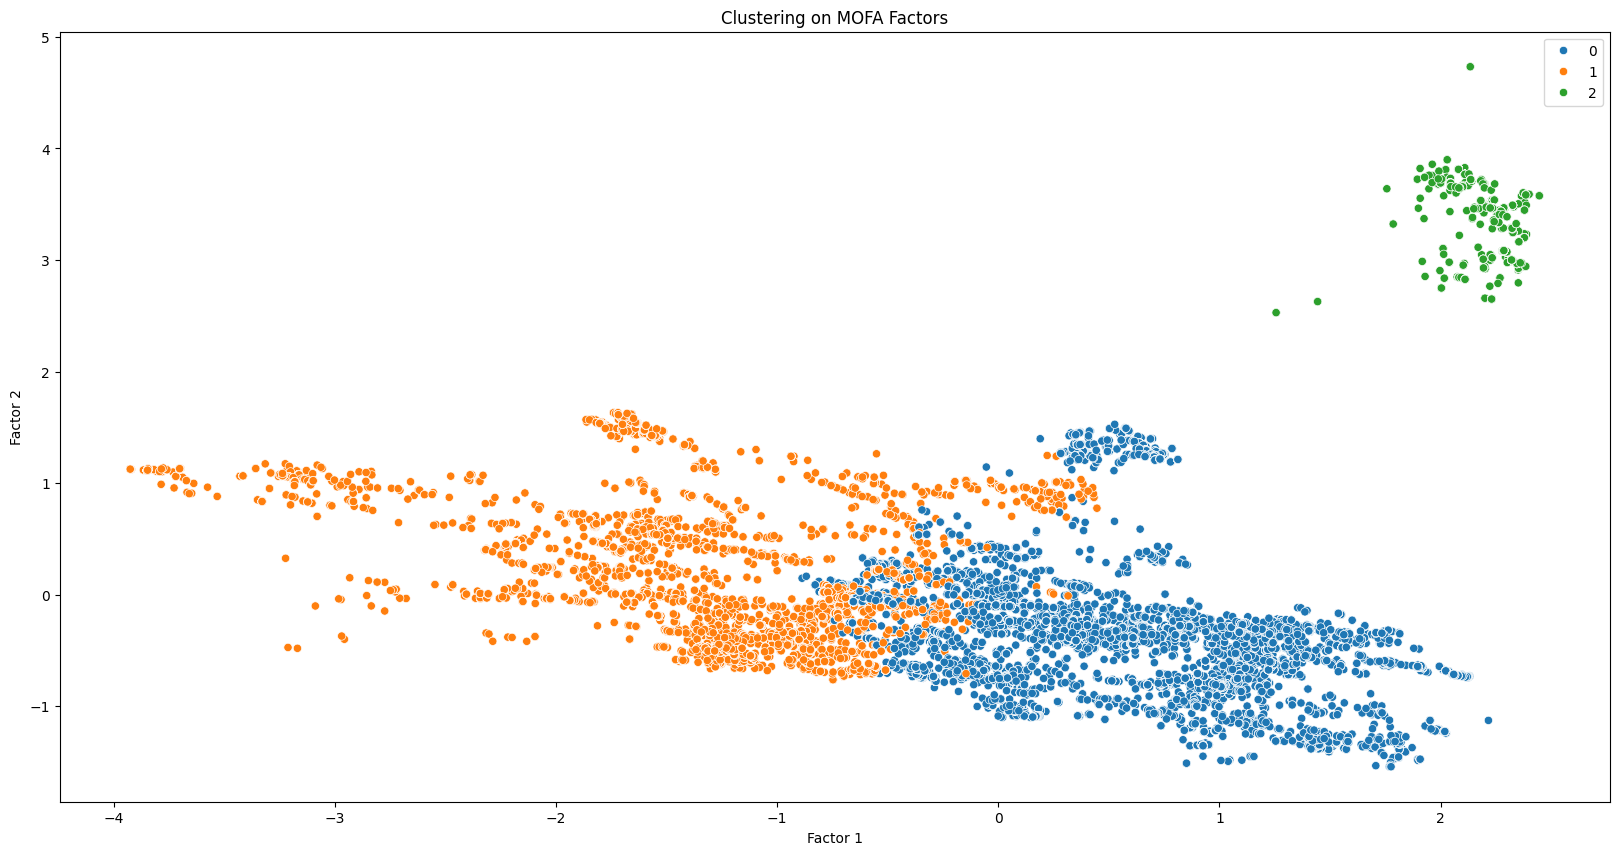

In [32]:

import mofax as mfx
import glob

# Load the MOFA model
files = glob.glob("trained_mofa_model_*.hdf5")
if not files:
    raise FileNotFoundError("No MOFA model files found!")

# Get the most recently modified file
latest_file = max(files, key=os.path.getmtime)
print(f"Loading most recent MOFA model: {latest_file}")

model = mfx.mofa_model(latest_file)

# Print model summary
print(model)

# Access factors
factors = model.get_factors()
# print("Factors:", factors)

# Access weights
weights = model.get_weights()
# print("Weights:", weights)

from sklearn.cluster import KMeans
import seaborn as sns

# Example: KMeans clustering on first 5 factors
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(factors[:, :5])  # use first 5 factors

# Visualize clusters using first two factors
plt.figure(figsize=(20, 10))
sns.scatterplot(x=factors[:,0], y=factors[:,1], hue=cluster_labels, palette='tab10')
plt.xlabel("Factor 1")
plt.ylabel("Factor 2")
plt.title("Clustering on MOFA Factors")
plt.show()

------------

In [10]:
# --- Prepare clinical labels and encode/drop specified columns ---
cols_to_drop = ['vital_status', 'cause_of_death', 'histology_diagnosis', 'case_id']
# Keep a copy of 'vital status' for downstream prediction (if present)
clin_labels = None
if clin is not None:
    if 'vital_status' in clin.columns:
        clin_labels = clin.loc[:, ['vital_status']].copy()
    else:
        print('Warning: "vital status" not found in clinical data')
    # Drop the undesired columns for MOFA input (we will keep other clinical features)
    clin_for_mofa = clin.drop(columns=cols_to_drop, errors='ignore')
    # Separate numeric and non-numeric features
    clin_numeric = clin_for_mofa.select_dtypes(include=[np.number])
    clin_categorical = clin_for_mofa.select_dtypes(exclude=[np.number])
    # Encode categorical features using one-hot encoding (keep NA as a category)
    if clin_categorical.shape[1] > 0:
        clin_cat_enc = pd.get_dummies(clin_categorical.astype(str), dummy_na=True, prefix_sep='__')
    else:
        clin_cat_enc = pd.DataFrame(index=clin_for_mofa.index)
    # Combine numeric + encoded categorical features for MOFA (samples will be rows later)
    if clin_numeric.shape[1] > 0 or clin_cat_enc.shape[1] > 0:
        clin_for_mofa_encoded = pd.concat([clin_numeric, clin_cat_enc], axis=1)
    else:
        clin_for_mofa_encoded = None
else:
    clin_for_mofa_encoded = None
    print('Clinical dataframe is None -- skipping clinical view')

print('Clinical label shape:', None if clin_labels is None else clin_labels.shape)
print('Clinical encoded features shape (for MOFA):', None if clin_for_mofa_encoded is None else clin_for_mofa_encoded.shape)

Clinical label shape: (140, 1)
Clinical encoded features shape (for MOFA): (140, 121)


In [ ]:
# --- Prepare views from omics (samples x features) and add clinical numeric view if present ---
sample_order = [str(s) for s in sorted(list(common))]
views = {}
for name, df in [('circ', circ_z), ('mir', mir_z), ('mrna', mrna_z), ('phospho', phospho_z), ('proteome', proteome_z), ('scna', scna_z)]:
    if df is None:
        continue
    mat = df.T.copy()  # samples x features
    mat.index = mat.index.astype(str)
    mat = mat.loc[mat.index.intersection(sample_order)]
    mat = mat.reindex(sample_order)
    nz_cols = mat.columns[mat.var(axis=0, skipna=True) != 0]
    mat = mat.loc[:, nz_cols]
    views[name] = mat

# Add clinical encoded view if available
if clin_for_mofa_encoded is not None and clin_for_mofa_encoded.shape[1] > 0:
    mat = clin_for_mofa_encoded.copy()
    try:
        mat.index = mat.index.astype(str)
        mat = mat.loc[mat.index.intersection(sample_order)]
        mat = mat.reindex(sample_order)
    except Exception:
        mat = mat.T
        mat.index = mat.index.astype(str)
        mat = mat.loc[mat.index.intersection(sample_order)]
        mat = mat.reindex(sample_order)
    nz_cols = mat.columns[mat.var(axis=0, skipna=True) != 0]
    mat = mat.loc[:, nz_cols]
    views['clinical'] = mat

ordered_names = [k for k in ['circ','mir','mrna','phospho','proteome','scna','clinical'] if k in views]
views_list = [views[k] for k in ordered_names]

In [ ]:
# --- Run MOFA: create entry_point, load views, set options, train, and save model ---
from mofapy2.run.entry_point import entry_point
ep = entry_point()
print('Created MOFA entry point (re-run)')
# Load each view using set_data_matrix(view_matrix, views_names=[viewname])
for vname, df in zip(ordered_names, views_list):
    mat_fx_s = df.T.values
    try:
        ep.set_data_matrix(mat_fx_s, views_names=[vname])
        print(f'Loaded view {vname} with shape (features x samples) = {mat_fx_s.shape}')
    except Exception as e_call:
        print(f'Failed loading view {vname}:', e_call)

ep.set_data_options()
ep.set_model_options(factors=10)
ep.set_train_options(seed=0)
ep.build()
ep.run()

output_file = 'trained_mofa_model.hdf5'
if os.path.exists(output_file):
    os.remove(output_file)
ep.save(output_file)
print(f'MOFA model re-run saved to {output_file}')

In [ ]:
# --- Load MOFA model, extract factors, attach vital status labels, and save CSV ---
import mofax as mfx
model = mfx.mofa_model(output_file)
factors = model.get_factors()  # shape: (n_samples, n_factors)
factors_df = pd.DataFrame(factors, index=sample_order, columns=[f'Factor_{i+1}' for i in range(factors.shape[1])])
# Attach vital status labels (if available) aligned to sample_order
if clin_labels is not None:
    vs = clin_labels.reindex(sample_order)
    if vs.shape[1] == 1:
        factors_df['vital_status'] = vs.iloc[:,0].values
    else:
        factors_df['vital_status'] = np.nan
else:
    factors_df['vital_status'] = np.nan
# Save combined factors + labels for future prediction steps
factors_df.to_csv('factors_with_vital_status.csv')
print('Saved factors with vital status to factors_with_vital_status.csv')